## Data Integrity Check: Timing Synchronization

This analysis calculates the average distance between the timing events recorded in the behavioral logs and the triggers received by the EEG amplifier.

We compare the cue_trial.started column from the PsychoPy file against the trigger timestamps for the Cue presentation. By contrasting these two time series, we derive an approximate metric for system delay. Furthermore, by plotting this difference across all triggers, we inspect the data for systematic delays (clock drift) versus random hardware jitter.

In [ ]:
import mne
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

sub_number = 's01'

In [67]:
# 1. Define the relative path from the working directory 
# First, the working directory should be set to the location of the jupyter notebook: project/scrips/eeg/
eeg_path_relative = '../../data/raw/pilot_01/eeg_data/loc_s01.vhdr'
raw = mne.io.read_raw_brainvision(eeg_path_relative, preload=True)

Extracting parameters from ../../data/raw/pilot_01/eeg_data/loc_s01.vhdr...
Setting channel info structure...
Reading 0 ... 3109759  =      0.000 ...  3109.759 secs...


In [ ]:
# Loading the behavioral dataframe for the encoding phase
beh_path_relative_enc = '../../data/raw/pilot_01/loc_label-encoding/1_2025-12-02_11h47.44.777.csv'
df_encoding = pd.read_csv(beh_path_relative_enc)

# Loading the behavioral dataframe for the retrieval phase
beh_path_relative_ret = '../../data/raw/pilot_01/loc_label-retrieval/1_2025-12-02_12h11.23.006.csv'
df_retrieval = pd.read_csv(beh_path_relative_ret)

## Extract MNE Triggers and their timings

In [ ]:
# 1. Get the events and the ID mapping
events, event_dict = mne.events_from_annotations(raw)

print("Found events:", events.shape)
print("Event IDs:", event_dict)

# 2. Identify the specific integer for your event of interest
# Example: If dict is {'Stimulus/S 10': 10}, use 'Stimulus/S 10'
cue_label_string = 'Stimulus/S206' # This corresponds to afc_prompt_prompt.started

if cue_label_string in event_dict:
    cue_id_integer = event_dict[cue_label_string]
    print(f"Filtering for Event ID: {cue_id_integer}")
    
    # 3. Filter the events array
    # events[:, 2] is the column with the Event IDs
    mne_cue_events = events[events[:, 2] == cue_id_integer]

    # 4. Get times
    mne_times = mne_cue_events[:, 0] / raw.info['sfreq']
    print(f"Final Count of Cue Triggers: {len(mne_times)}")

else:
    print(f"Error: '{cue_label_string}' not found in event_dict. Keys are: {list(event_dict.keys())}")

Used Annotations descriptions: [np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S 43'), np.str_('Stimulus/S 50'), np.str_('Stimulus/S 51'), np.str_('Stimulus/S100'), np.str_('Stimulus/S101'), np.str_('Stimulus/S102'), np.str_('Stimulus/S103'), np.str_('Stimulus/S104'), np.str_('Stimulus/S105'), np.str_('Stimulus/S106'), np.str_('Stimulus/S107'), np.str_('Stimulus/S108'), np.str_('Stimulus/S199'), np.str_('Stimulus/S200'), np.str_('Stimulus/S201'), np.str_('Stimulus/S202'), np.str_('Stimulus/S203'), np.str_('Stimulus/S204'), np.str_('Stimulus/S205'), np.str_('Stimulus/S206'), np.str_('Stimulus/S207')]
Found events: (1219, 3)
Event IDs: {np.str_('Stimulus/S  1'): 1, np.str_('Stimulus/S  2'): 2, np.str_('Stimulus/S  3'): 3, np.str_('Stimulus/S 43'): 43, np.str_('Stimulus/S 50'): 50, np.str_('Stimulus/S 51'): 51, np.str_('Stimulus/S100'): 100, np.str_('Stimulus/S101'): 101, np.str_('Stimulus/S102'): 102, np.str_('Stimulus/S103'): 103, np.str_

In [22]:
# Extract the PsychoPy times for when the cue image was onset during ENCODING
pp_times_cue = df_encoding['cue_trial.started'].dropna().to_numpy()
print('Number of timings for cue onset:', len(pp_times_cue))

pp_times_target = df_encoding['target_trial.started'].dropna().to_numpy()
print('Number of timings for target onset:', len(pp_times_target))

# The number of timings in the encoding behavioral dataframe does not match the trigger counts from above


Number of timings for cue onset: 72
Number of timings for target onset: 72


In [ ]:
# Extract the PsychoPy times for when the AFC prompt during RETRIEVAL
# This corresponds to trigger code 206
ret_times_cue = df_retrieval['afc_prompt.started'].dropna().to_numpy()
print('Number of timings for ending recognition prompt:', len(ret_times_cue))

# With afc_prompt_started, the trigger (206) & behavioral timings converge on N = 64. For the other columns of the CSV,
# I also get 64 timings BUT we have 84 trigger for those. Why?

print('First 5 absolute timings for ending recognition prompt:', ret_times_cue[0:5])
print('First 5 absolute timings for TRIGGER of ending recognition prompt:', mne_times[0:5])

Number of timings for ending recognition prompt: 64
First 5 absolute timings for ending recognition prompt: [ 25.4031608  75.4158636  95.7239296 118.0369293 148.5963254]
First 5 absolute timings for TRIGGER of ending recognition prompt: [1883.662 1933.68  1953.989 1976.302 2006.862]


In [65]:
# Align starting times to t=0
ret_times_relative = ret_times_cue - ret_times_cue[0]
mne_relative = mne_times - mne_times[0]

print('First 5 rel timings for ending recognition prompt:', ret_times_relative[0:5])
print('First 5 rel timings for TRIGGER of ending recognition prompt:', mne_relative[0:5])

# Calculate the difference between the two time series
lag_timings = mne_relative - ret_times_relative
lag_timings_ms = lag_timings * 1000
print('First 5 lags in milliseconds:', lag_timings_ms[0:5])

# Statistics
avg_offset = np.mean(lag_timings_ms)
std_offset = np.std(lag_timings_ms) 
ending_offset = lag_timings_ms[-1] # What was the difference at the last trial?

print(f"--- RESULTS ---")
print(f"Average Drift per trial: {avg_offset:.4f} ms")
print(f"Jitter (Standard Dev):   {std_offset:.4f} ms")
print(f"Total Drift by trial 75: {ending_offset:.4f} ms")

First 5 rel timings for ending recognition prompt: [  0.         50.0127028  70.3207688  92.6337685 123.1931646]
First 5 rel timings for TRIGGER of ending recognition prompt: [  0.     50.018  70.327  92.64  123.2  ]
First 5 lags in milliseconds: [0.         5.29720002 6.23120002 6.23150005 6.83540006]
--- RESULTS ---
Average Drift per trial: 11.0111 ms
Jitter (Standard Dev):   3.5282 ms
Total Drift by trial 75: 15.8198 ms


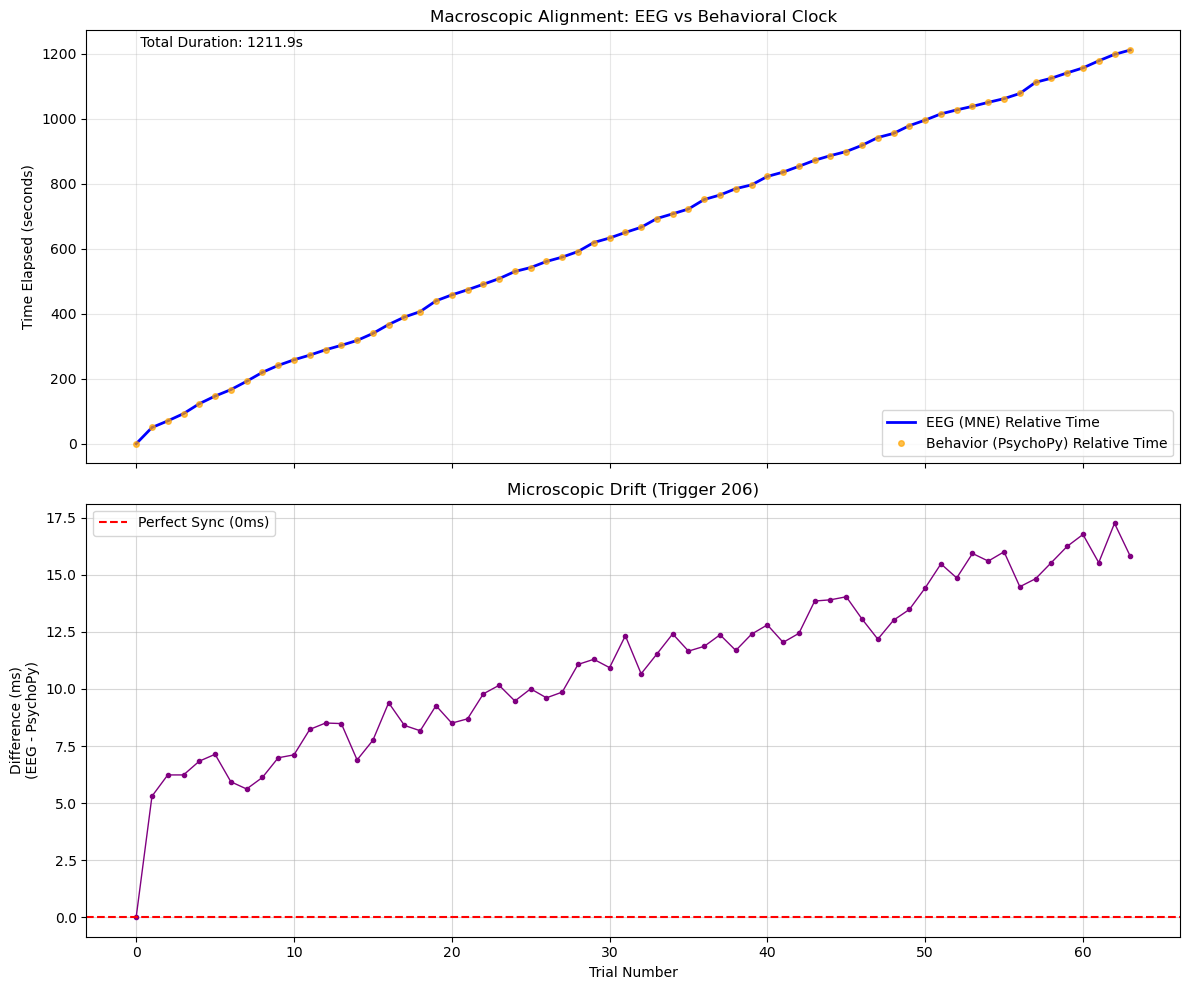

In [66]:
# 4. Visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# --- PLOT 1: The Raw Relative Time Series ---
# We use a solid line for EEG and circles for PsychoPy to distinguish them if they overlap
ax1.plot(mne_relative, color='blue', linewidth=2, label='EEG (MNE) Relative Time')
ax1.plot(ret_times_relative, color='orange', linestyle='', marker='o', markersize=4, alpha=0.7, label='Behavior (PsychoPy) Relative Time')

ax1.set_ylabel('Time Elapsed (seconds)')
ax1.set_title('Macroscopic Alignment: EEG vs Behavioral Clock')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Add a text annotation showing total duration
total_duration = mne_relative[-1]
ax1.text(0, total_duration, f" Total Duration: {total_duration:.1f}s", verticalalignment='bottom')


# --- PLOT 2: The Difference (Zoomed In) ---
ax2.plot(lag_timings_ms, color='purple', marker='.', linestyle='-', linewidth=1)
ax2.axhline(0, color='red', linestyle='--', label='Perfect Sync (0ms)')

ax2.set_ylabel('Difference (ms)\n(EEG - PsychoPy)')
ax2.set_xlabel('Trial Number')
ax2.set_title(f'Microscopic Drift (Trigger {206})')
ax2.legend()
ax2.grid(True, alpha=0.5)

plt.tight_layout()
plt.show()